# Gradient Checking


## Table of Contents
- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - How Gradient Checking works](#3)
- [4 - 1-Dimensional Gradient Checking](#4)
- [5 - N-Dimensional Gradient Checking](#5)

<a name='1'></a>
## 1 - Packages

In [ ]:
import numpy as np
from gc_utils import sigmoid, relu, dictionary_to_vector, vector_to_dictionary, gradients_to_vector

%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Problem Statement

We are trying to build a deep learning model to detect fraud--whenever someone makes a payment, we want to see if the payment might be fraudulent, such as if the user's account has been taken over by a hacker. We already know that backpropagation is quite challenging to implement, and sometimes has bugs. To give proof that backpropagation is actually working, we can use a technique called gradient checking.

<a name='3'></a>
## 3 - How Gradient Checking works
Backpropagation computes the gradients $\frac{\partial J}{\partial \theta}$, where $\theta$ denotes the parameters of the model. $J$ is computed using forward propagation and our loss function.

We can use our code for computing $J$ to verify the code for computing $\frac{\partial J}{\partial \theta}$.

Let's look back at the definition of a derivative (or gradient):$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} $$

$\frac{\partial J}{\partial \theta}$ is what we want to make sure we're computing correctly.
We can compute $J(\theta + \varepsilon)$ and $J(\theta - \varepsilon)$ (in the case that $\theta$ is a real number), since we're confident the implementation for $J$ is correct.

<a name='4'></a>
## 4 - 1-Dimensional Gradient Checking

Consider a 1D linear function $J(\theta) = \theta x$. The model contains only a single real-valued parameter $\theta$, and takes $x$ as input.

I will implement code to compute $J(.)$ and its derivative $\frac{\partial J}{\partial \theta}$. I will then use gradient checking to make sure my derivative computation for $J$ is correct.

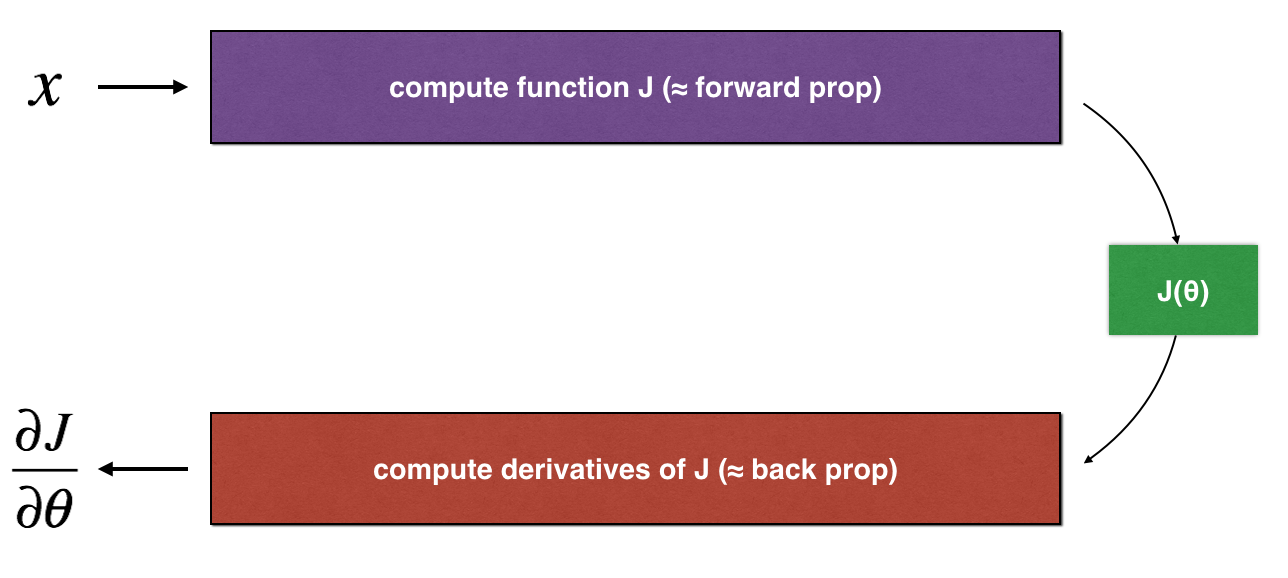

The diagram above shows the key computation steps: First start with $x$, then evaluate the function $J(x)$ ("forward propagation"). Then compute the derivative $\frac{\partial J}{\partial \theta}$ ("backward propagation").


In [ ]:
def forward_propagation(x, theta):
    """
    Implement the linear forward propagation (compute J) presented in Figure 1 (J(theta) = theta * x)

    Arguments:
    x -- a real-valued input
    theta -- our parameter, a real number as well

    Returns:
    J -- the value of function J, computed using the formula J(theta) = theta * x
    """

    J = theta * x

    return J

In [ ]:
def backward_propagation(x, theta):
    """
    Computes the derivative of J with respect to theta (see Figure 1).

    Arguments:
    x -- a real-valued input
    theta -- our parameter, a real number as well

    Returns:
    dtheta -- the gradient of the cost with respect to theta
    """

    dtheta = x

    return dtheta

In [ ]:
def gradient_check(x, theta, epsilon=1e-7, print_msg=False):
    """
    Implement the backward propagation presented in Figure 1.

    Arguments:
    x -- a float input
    theta -- our parameter, a float as well
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)

    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient. Float output
    """

    theta_plus = theta + epsilon
    theta_minus = theta - epsilon
    J_plus = forward_propagation(x, theta_plus)
    J_minus = forward_propagation(x, theta_minus)
    gradapprox = (J_plus - J_minus)/(2*epsilon)

    # Check if gradapprox is close enough to the output of backward_propagation()
    grad = backward_propagation(x, theta)

    numerator = np.linalg.norm(grad - gradapprox)
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
    difference = numerator / denominator

    if print_msg:
        if difference > 2e-7:
            print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print ("\033[92m" + "Backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

    return difference

<a name='5'></a>
## 5 - N-Dimensional Gradient Checking

The following figure describes the forward and backward propagation of the fraud detection model.

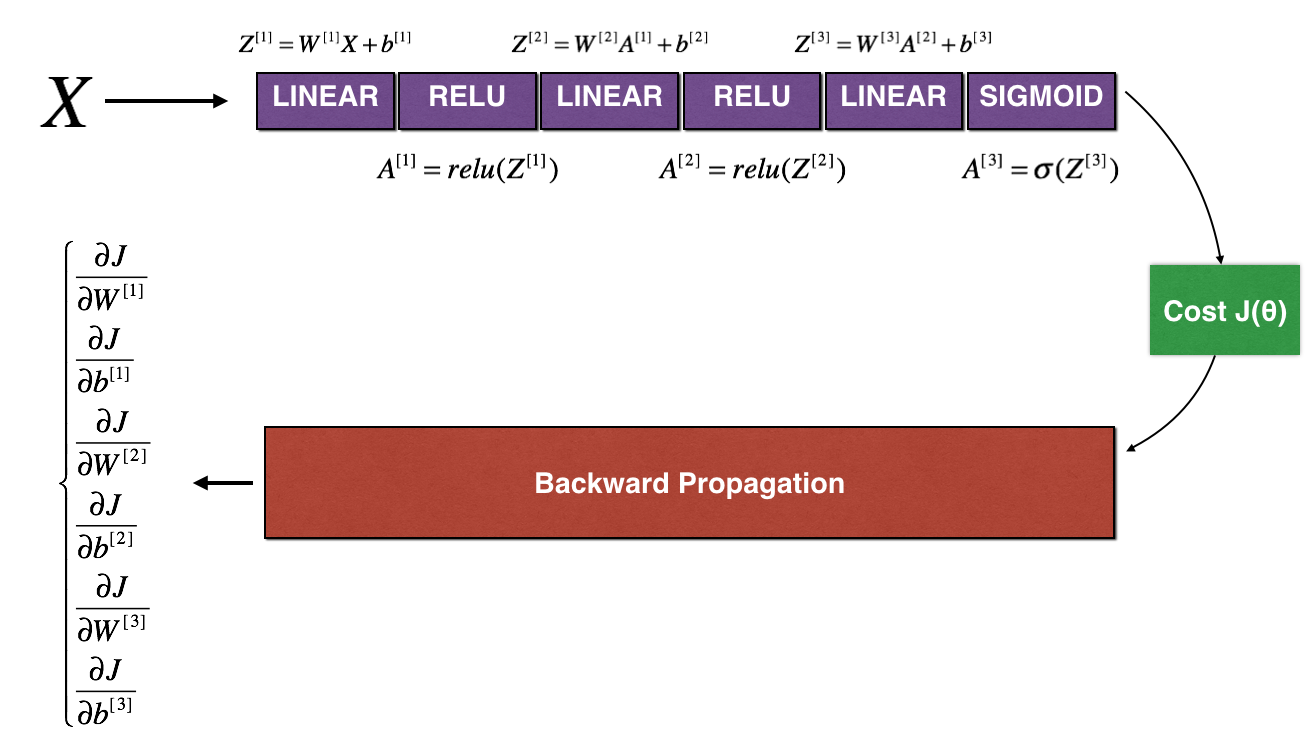

In [ ]:
def forward_propagation_n(X, Y, parameters):
    """
    Arguments:
    X -- training set for m examples
    Y -- labels for m examples
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (5, 4)
                    b1 -- bias vector of shape (5, 1)
                    W2 -- weight matrix of shape (3, 5)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)

    Returns:
    cost -- the cost function (logistic cost for one example)
    cache -- a tuple with the intermediate values (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    """

    # retrieve parameters
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # Cost
    log_probs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    cost = 1. / m * np.sum(log_probs)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return cost, cache

In [ ]:
def backward_propagation_n(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.

    Arguments:
    X -- input datapoint, of shape (input size, 1)
    Y -- true "label"
    cache -- cache output from forward_propagation_n()

    Returns:
    gradients -- A dictionary with the gradients of the cost with respect to each parameter, activation and pre-activation variables.
    """

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

**How does gradient checking work?**.

We want to compare "gradapprox" to the gradient computed by backpropagation. The formula is still:

$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

However, $\theta$ is not a scalar anymore. It is a dictionary called "parameters". The  function "`dictionary_to_vector()`" converts the "parameters" dictionary into a vector called "values", obtained by reshaping all parameters (W1, b1, W2, b2, W3, b3) into vectors and concatenating them.

The inverse function is "`vector_to_dictionary`" which outputs back the "parameters" dictionary.


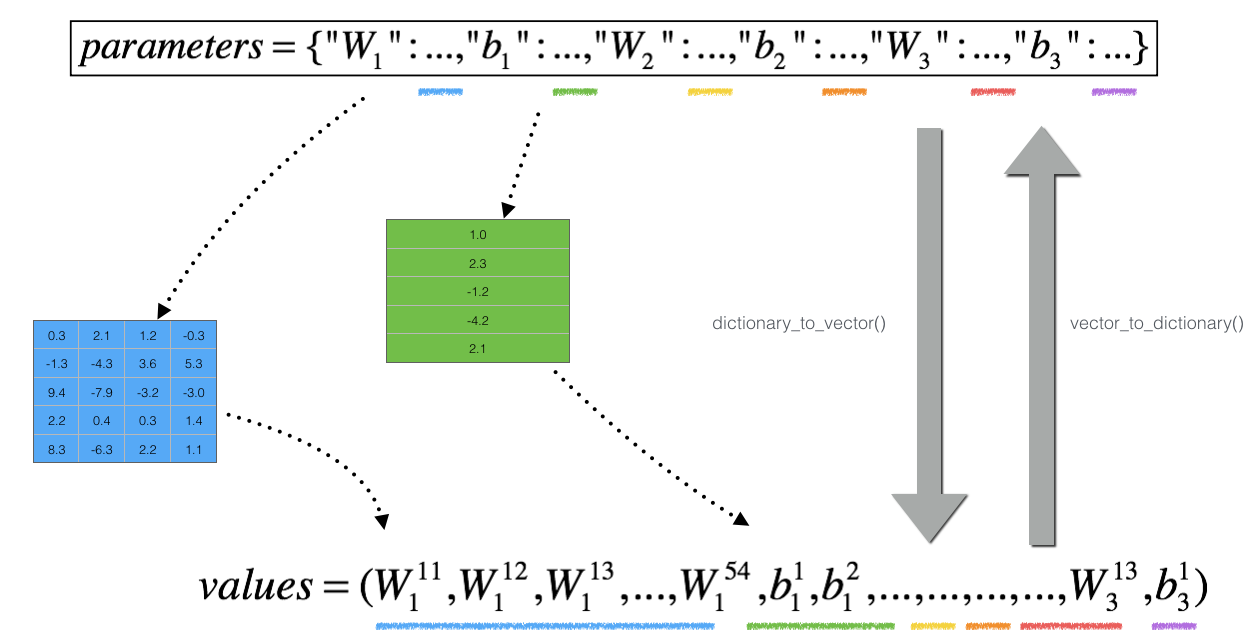

Now, for every single parameter in a vector, we will apply the same procedure as for gradient_check. We will store each gradient approximation in a vector `gradapprox`. If the check goes as expected, each value in this approximation must match the real gradient values stored in the `grad` vector.



In [ ]:
def gradient_check_n(parameters, gradients, X, Y, epsilon=1e-7, print_msg=False):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n

    Arguments:
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters.
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)

    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """

    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)

    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))

    # Compute gradapprox
    for i in range(num_parameters):

        theta_plus = np.copy(parameters_values)
        theta_plus[i][0] = theta_plus[i][0] + epsilon
        J_plus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(theta_plus))

        theta_minus = np.copy(parameters_values)
        theta_minus[i][0] = theta_minus[i][0] - epsilon
        J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(theta_minus))

        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2*epsilon)

    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
    difference = numerator/denominator
    if print_msg:
        if difference > 2e-7:
            print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print ("\033[92m" + "Backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

    return difference

**Notes**:
- Gradient checking verifies closeness between the gradients from backpropagation and the numerical approximation of the gradient (computed using forward propagation).
- Gradient checking is slow, so we don't want to run it in every iteration of training. We would usually run it only to make sure our code is correct, then turn it off and use backprop for the actual learning process.